# Лабораторная работа №5. Проведение исследований с градиентным бустингом

Импорт библиотек и настройки окружения\
Градиентный бустинг для классификации и регрессии: загрузка, метрики, визуализации

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

pd.set_option("display.max_columns", 120)
RANDOM_STATE = 42
sns.set_theme(style="whitegrid")



Загрузка датасетов\
COVID (классификация) и страховые выплаты (регрессия)

In [2]:
covid_path = Path("../datasets/covid.csv")
insurance_path = Path("../datasets/insurance.csv")

df_covid_raw = pd.read_csv(covid_path)
df_insurance_raw = pd.read_csv(insurance_path)

Вспомогательные функции для метрик и графиков\
Унификация метрик, таблицы, ROC/PR, ошибки и важности

In [3]:
def classification_report_dict(y_true, y_pred, y_proba=None):
    scores = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    if y_proba is not None:
        try:
            scores["roc_auc"] = roc_auc_score(y_true, y_proba)
        except ValueError:
            scores["roc_auc"] = np.nan
    return scores


def regression_report_dict(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "r2": r2_score(y_true, y_pred),
    }


def show_results_table(results, title):
    print(f"\n{title}")
    display_df = pd.DataFrame(results).T
    display_df = display_df.round(4)
    print(display_df)


def plot_confusion(cm, title):
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_roc_pr(y_true, proba_dict):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for label, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC-кривые")
    plt.legend()

    plt.subplot(1, 2, 2)
    for label, proba in proba_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, proba)
        plt.plot(recall, precision, label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_residuals(true, preds_dict):
    plt.figure(figsize=(8, 4))
    for label, pred in preds_dict.items():
        residuals = true - pred
        sns.kdeplot(residuals, label=label, fill=True, alpha=0.3)
    plt.title("Плотности остатков моделей")
    plt.xlabel("Ошибка (true - pred)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_predictions(true, preds_dict):
    plt.figure(figsize=(12, 5))
    for i, (label, pred) in enumerate(preds_dict.items()):
        plt.subplot(1, len(preds_dict), i + 1)
        sns.scatterplot(x=true, y=pred, alpha=0.6)
        m, M = true.min(), true.max()
        plt.plot([m, M], [m, M], "r--")
        plt.title(f"{label}: true vs pred")
        plt.xlabel("true")
        plt.ylabel("pred")
    plt.tight_layout()
    plt.show()


def plot_feature_importance(importances, feature_names, title, top_n=15):
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_df = imp_df.reindex(imp_df.importance.abs().sort_values(ascending=False).index)
    imp_df = imp_df.head(top_n)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=imp_df, x="importance", y="feature")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Подготовка COVID данных для классификации\
Таргет: died, добавляем COVID_POSITIVE, заменяем коды пропусков

In [4]:
covid_df = df_covid_raw.copy()
covid_df["died"] = (covid_df["DATE_DIED"] != "9999-99-99").astype(int)
covid_df["COVID_POSITIVE"] = (covid_df["CLASIFFICATION_FINAL"] <= 3).astype(int)
covid_df = covid_df.drop(columns=["DATE_DIED"])

covid_df = covid_df.replace({97: np.nan, 98: np.nan, 99: np.nan})
feature_cols_covid = [c for c in covid_df.columns if c != "died"]

covid_sample = covid_df.sample(n=80000, random_state=RANDOM_STATE)

COVID EDA: распределения и риски\
Распределение таргета, возраст, корреляции, влияние коморбидностей

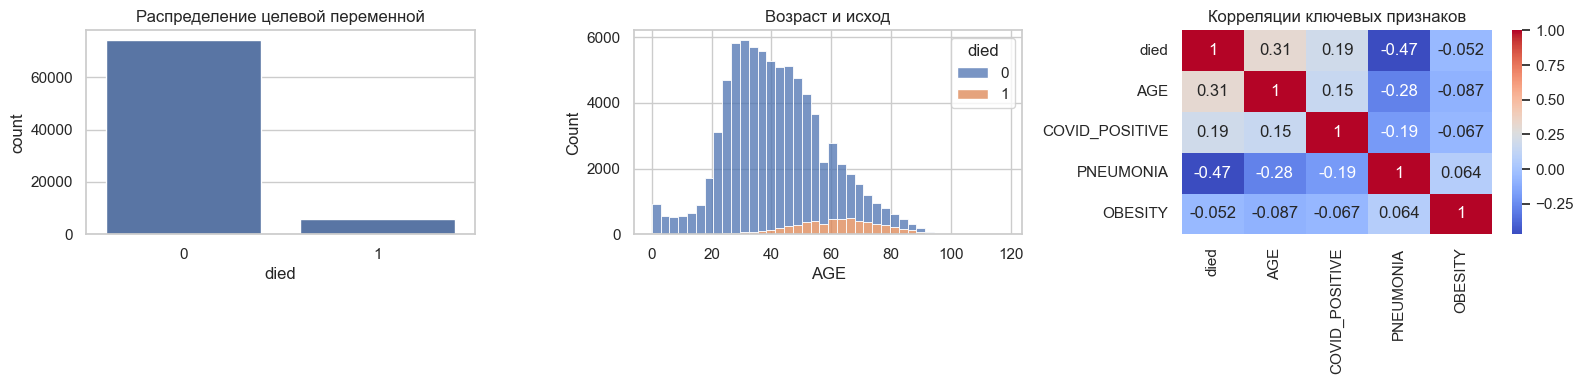

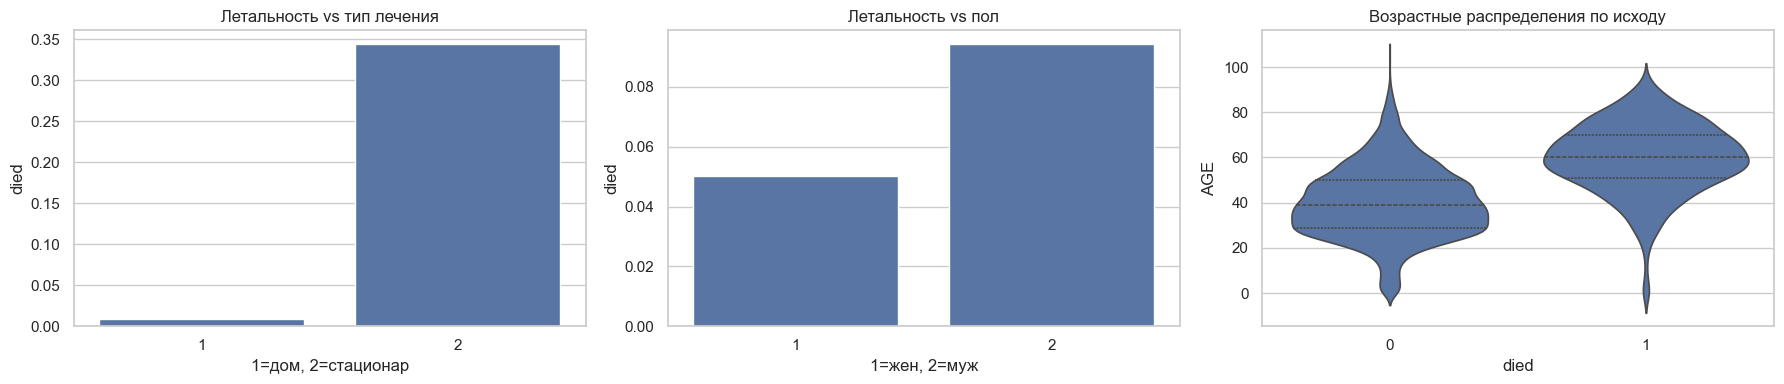

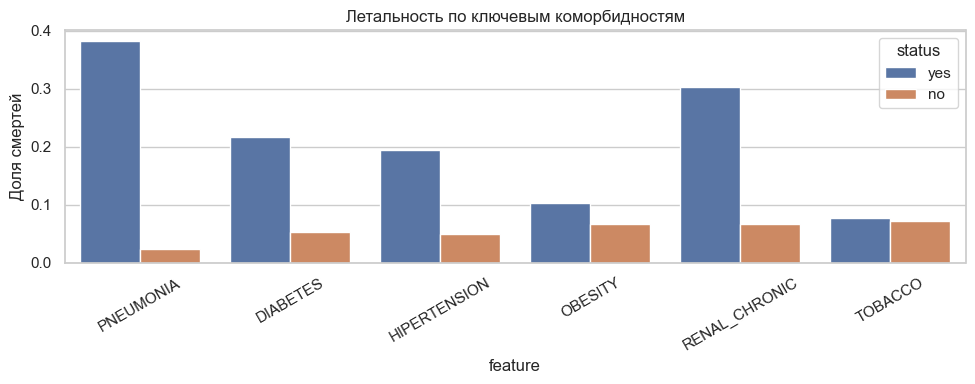

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(data=covid_sample, x="died", ax=axes[0])
axes[0].set_title("Распределение целевой переменной")

sns.histplot(
    data=covid_sample,
    x="AGE",
    hue="died",
    multiple="stack",
    bins=40,
    ax=axes[1],
)
axes[1].set_title("Возраст и исход")

corr_subset = covid_sample[["died", "AGE", "COVID_POSITIVE", "PNEUMONIA", "OBESITY"]]
sns.heatmap(corr_subset.corr(), annot=True, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Корреляции ключевых признаков")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(
    data=covid_sample,
    x="PATIENT_TYPE",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[0],
)
axes[0].set_title("Летальность vs тип лечения")
axes[0].set_xlabel("1=дом, 2=стационар")

sns.barplot(
    data=covid_sample,
    x="SEX",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[1],
)
axes[1].set_title("Летальность vs пол")
axes[1].set_xlabel("1=жен, 2=муж")

sns.violinplot(
    data=covid_sample.sample(8000, random_state=RANDOM_STATE),
    x="died",
    y="AGE",
    inner="quart",
    ax=axes[2],
)
axes[2].set_title("Возрастные распределения по исходу")
plt.tight_layout()
plt.show()

risk_cols = ["PNEUMONIA", "DIABETES", "HIPERTENSION", "OBESITY", "RENAL_CHRONIC", "TOBACCO"]

risk_records = []
for col in risk_cols:
    yes_mean = covid_sample.loc[covid_sample[col] == 1, "died"].mean()
    no_mean = covid_sample.loc[covid_sample[col] == 2, "died"].mean()
    risk_records.append({"feature": col, "status": "yes", "mortality": yes_mean})
    risk_records.append({"feature": col, "status": "no", "mortality": no_mean})

risk_df = pd.DataFrame(risk_records)
plt.figure(figsize=(10, 4))
sns.barplot(data=risk_df, x="feature", y="mortality", hue="status")
plt.xticks(rotation=30)
plt.title("Летальность по ключевым коморбидностям")
plt.ylabel("Доля смертей")
plt.tight_layout()
plt.show()

Бейзлайн градиентного бустинга (классификация)\
Пайплайн: импутация, скейлинг, GradientBoostingClassifier с базовыми параметрами

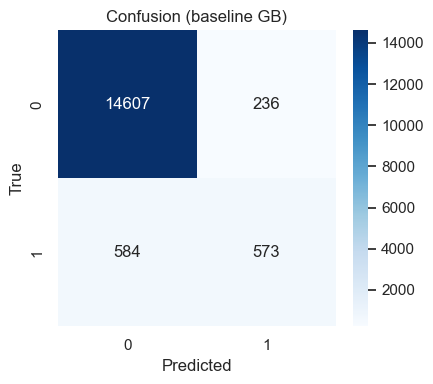

In [6]:
X_covid = covid_sample[feature_cols_covid]
y_covid = covid_sample["died"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_covid, y_covid, test_size=0.2, stratify=y_covid, random_state=RANDOM_STATE
)

gb_baseline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        (
            "model",
            GradientBoostingClassifier(
                n_estimators=120,
                learning_rate=0.08,
                max_depth=3,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

gb_baseline.fit(X_train_c, y_train_c)
base_pred = gb_baseline.predict(X_test_c)
base_proba = gb_baseline.predict_proba(X_test_c)[:, 1]

results_cls = {}
results_cls["baseline_gb"] = classification_report_dict(y_test_c, base_pred, base_proba)

plot_confusion(confusion_matrix(y_test_c, base_pred), "Confusion (baseline GB)")

Тюнинг градиентного бустинга (классификация)\
GridSearchCV по числу деревьев, глубине, learning_rate и subsample

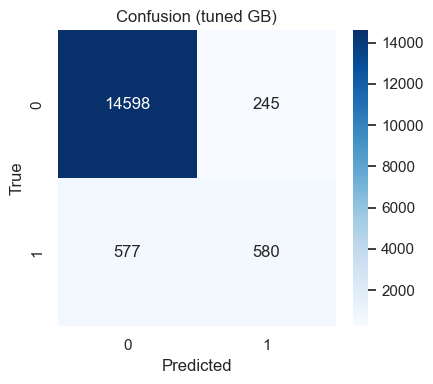

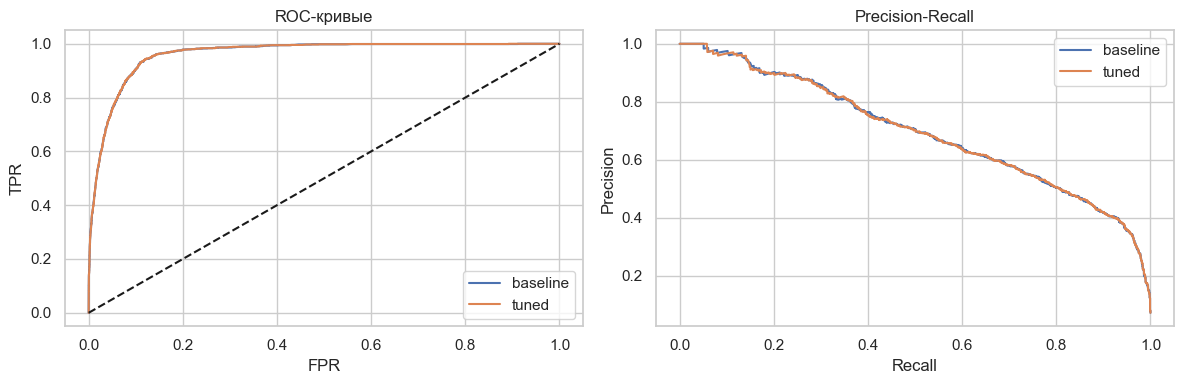

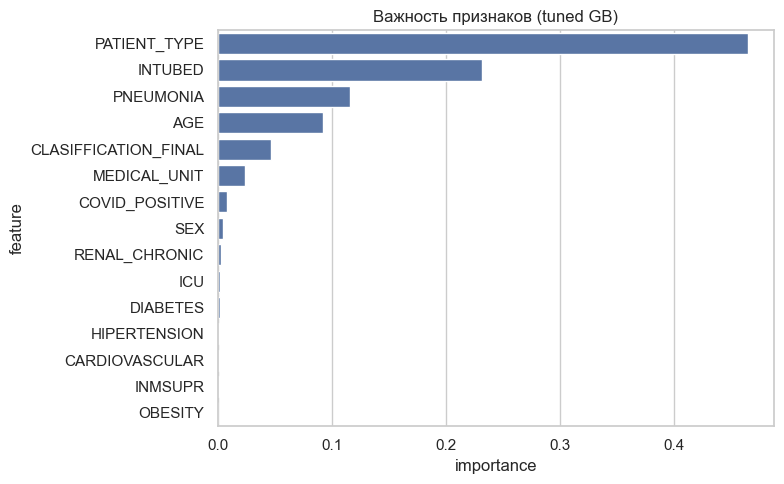

In [7]:
param_grid_cls = {
    "model__n_estimators": [80, 150, 220],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 4],
    "model__subsample": [0.7, 1.0],
}

cv_cls = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

gb_search = GridSearchCV(
    estimator=gb_baseline,
    param_grid=param_grid_cls,
    scoring="f1",
    cv=cv_cls,
    n_jobs=-1,
)
gb_search.fit(X_train_c, y_train_c)

best_gb_cls = gb_search.best_estimator_
best_pred = best_gb_cls.predict(X_test_c)
best_proba = best_gb_cls.predict_proba(X_test_c)[:, 1]

results_cls["tuned_gb"] = classification_report_dict(y_test_c, best_pred, best_proba)

plot_confusion(confusion_matrix(y_test_c, best_pred), "Confusion (tuned GB)")
plot_roc_pr(y_test_c, {"baseline": base_proba, "tuned": best_proba})

feature_importances_cls = best_gb_cls.named_steps["model"].feature_importances_
plot_feature_importance(feature_importances_cls, feature_cols_covid, "Важность признаков (tuned GB)")

Кастомная имплементация градиентного бустинга (классификация)\
Реализация логистического бустинга на решающих деревьях-регрессорах

In [8]:
class SimpleGBClassifier:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=2, min_samples_leaf=1, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        rng = np.random.default_rng(self.random_state)
        self.trees_ = []
        self.classes_ = np.array([0, 1])
        # стартовые логиты = 0
        self.init_pred_ = np.zeros(X.shape[0])
        pred = self.init_pred_.copy()
        for i in range(self.n_estimators):
            p = self._sigmoid(pred)
            residual = y - p  # отрицательный градиент логистической потери
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state + i,
            )
            tree.fit(X, residual)
            update = tree.predict(X)
            pred += self.learning_rate * update
            self.trees_.append(tree)
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        pred = np.zeros(X.shape[0])
        for tree in self.trees_:
            pred += self.learning_rate * tree.predict(X)
        p = self._sigmoid(pred)
        return np.vstack([1 - p, p]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

Оценка кастомного бустинга (классификация) на компактной выборке

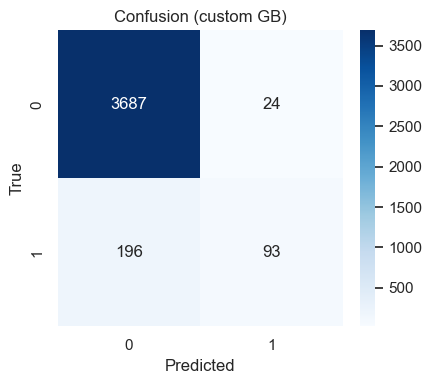


Метрики классификации (градиентный бустинг)
             accuracy  precision  recall      f1  roc_auc
baseline_gb    0.9488     0.7083  0.4952  0.5829   0.9619
tuned_gb       0.9486     0.7030  0.5013  0.5853   0.9619
custom_gb      0.9450     0.7949  0.3218  0.4581   0.9489


In [9]:
X_c_small, _, y_c_small, _ = train_test_split(
    X_covid,
    y_covid,
    train_size=20000,
    stratify=y_covid,
    random_state=RANDOM_STATE,
)

X_train_cs, X_test_cs, y_train_cs, y_test_cs = train_test_split(
    X_c_small,
    y_c_small,
    test_size=0.2,
    stratify=y_c_small,
    random_state=RANDOM_STATE,
)

custom_gb_cls = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        (
            "model",
            SimpleGBClassifier(
                n_estimators=60,
                learning_rate=0.1,
                max_depth=2,
                min_samples_leaf=10,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

custom_gb_cls.fit(X_train_cs, y_train_cs)
custom_pred = custom_gb_cls.predict(X_test_cs)
custom_proba = custom_gb_cls.predict_proba(X_test_cs)[:, 1]

results_cls["custom_gb"] = classification_report_dict(
    y_test_cs, custom_pred, custom_proba
)

plot_confusion(confusion_matrix(y_test_cs, custom_pred), "Confusion (custom GB)")

show_results_table(results_cls, "Метрики классификации (градиентный бустинг)")

Подготовка страховых данных под регрессию\
ColumnTransformer для числовых и категориальных признаков

In [10]:
insurance_df = df_insurance_raw.copy()
reg_target = insurance_df["charges"]
reg_features = insurance_df.drop(columns=["charges"])

num_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
        ),
    ]
)

reg_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

EDA по страховым данным\
Распределения выплат, влияние курения/региона, тренды по возрасту

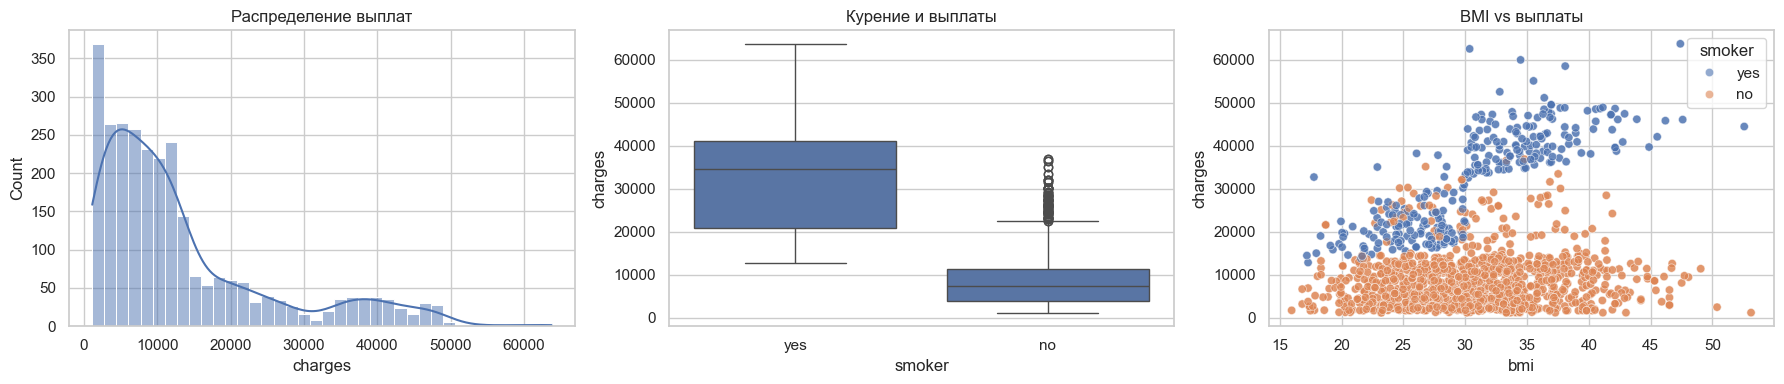

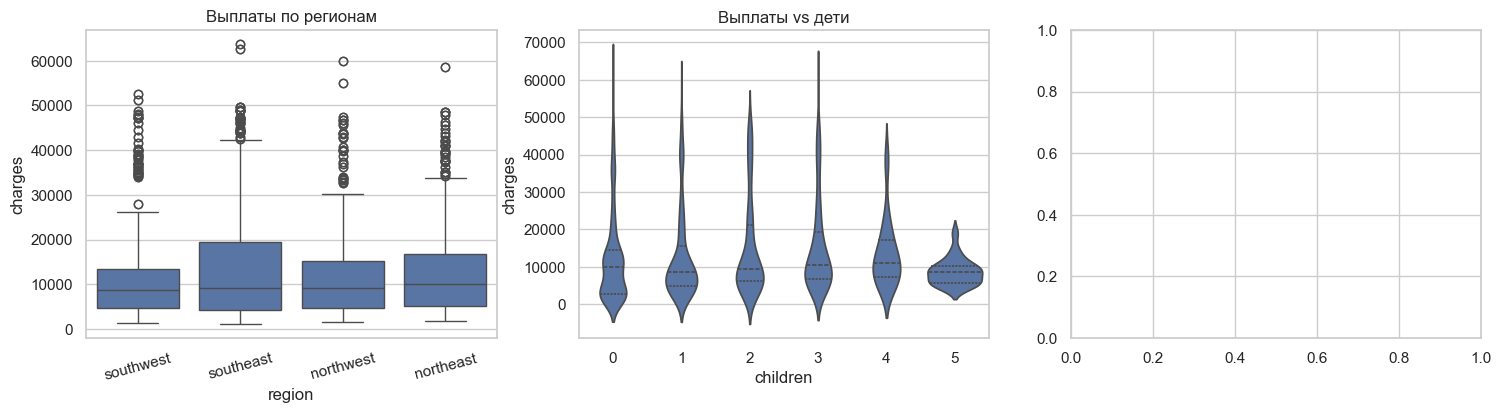

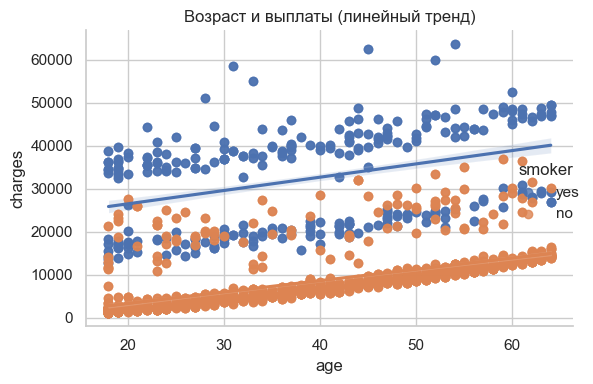

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(reg_target, kde=True, ax=axes[0])
axes[0].set_title("Распределение выплат")

sns.boxplot(data=insurance_df, x="smoker", y="charges", ax=axes[1])
axes[1].set_title("Курение и выплаты")

sns.scatterplot(
    data=insurance_df,
    x="bmi",
    y="charges",
    hue="smoker",
    alpha=0.6,
    ax=axes[2],
)
axes[2].set_title("BMI vs выплаты")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.boxplot(data=insurance_df, x="region", y="charges", ax=axes[0])
axes[0].set_title("Выплаты по регионам")
axes[0].tick_params(axis="x", rotation=15)

sns.violinplot(data=insurance_df, x="children", y="charges", inner="quart", ax=axes[1])
axes[1].set_title("Выплаты vs дети")

sns.lmplot(data=insurance_df, x="age", y="charges", hue="smoker", height=4, aspect=1.3)
plt.title("Возраст и выплаты (линейный тренд)")
plt.tight_layout()
plt.show()

Бейзлайн градиентного бустинга (регрессия)\
Пайплайн: препроцессинг + GradientBoostingRegressor

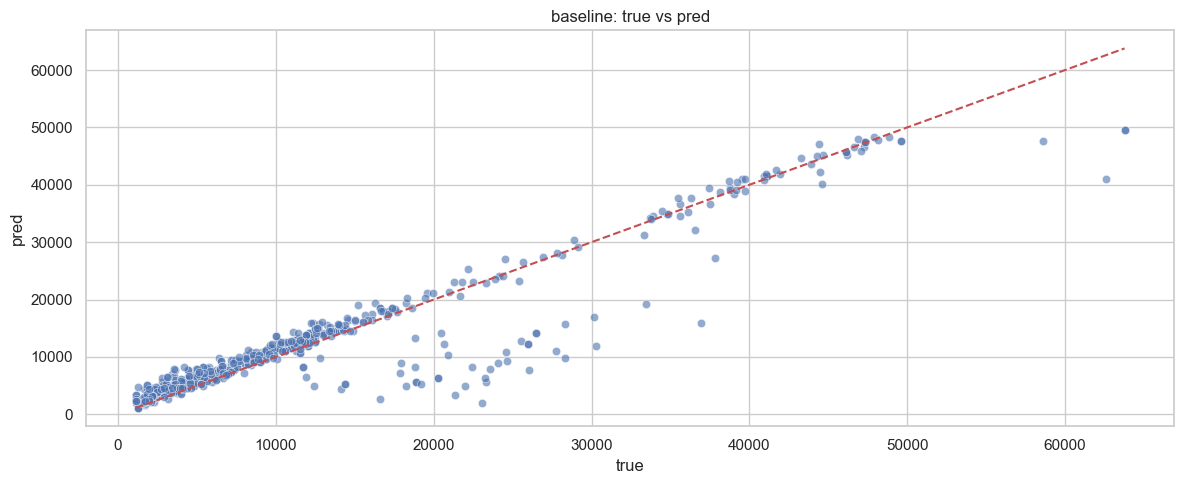

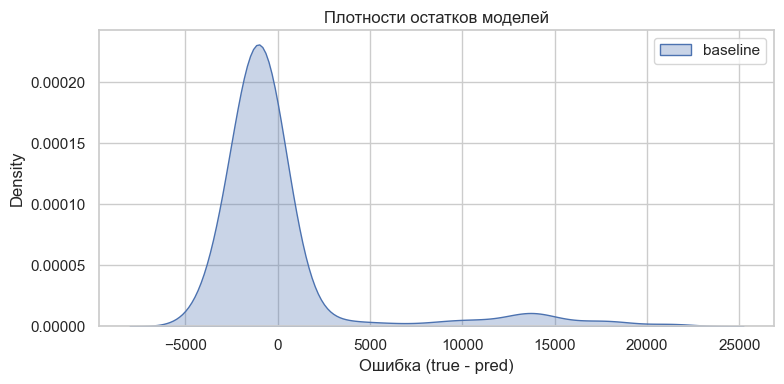

In [12]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    reg_features, reg_target, test_size=0.2, random_state=RANDOM_STATE
)

gb_reg_baseline = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        (
            "model",
            GradientBoostingRegressor(
                n_estimators=160,
                learning_rate=0.08,
                max_depth=3,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

gb_reg_baseline.fit(X_train_r, y_train_r)
base_pred_reg = gb_reg_baseline.predict(X_test_r)

results_reg = {}
results_reg["baseline_gb"] = regression_report_dict(y_test_r, base_pred_reg)

plot_predictions(y_test_r, {"baseline": base_pred_reg})
plot_residuals(y_test_r, {"baseline": base_pred_reg})

Тюнинг градиентного бустинга (регрессия)\
GridSearchCV по числу деревьев, глубине, learning_rate и subsample

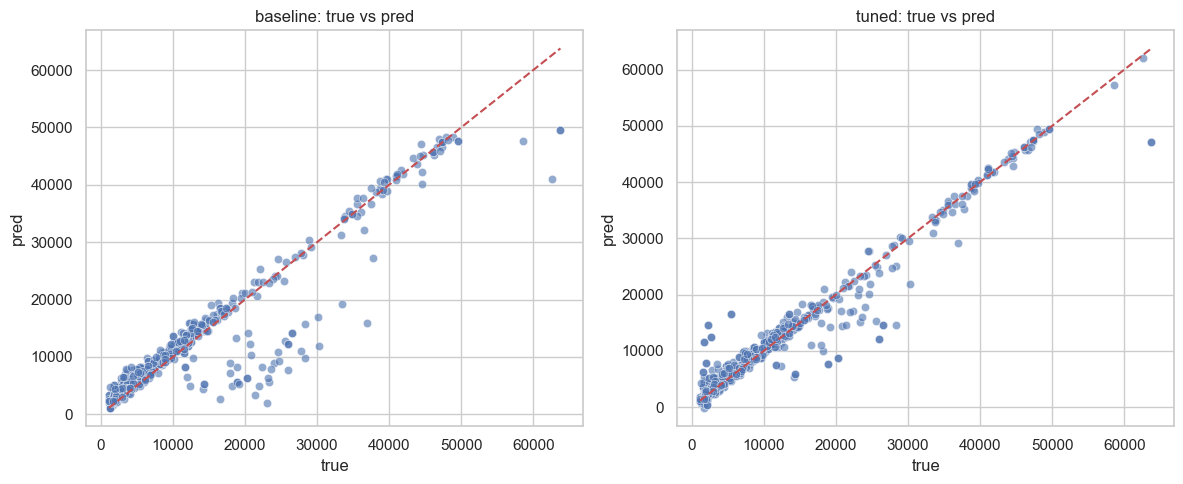

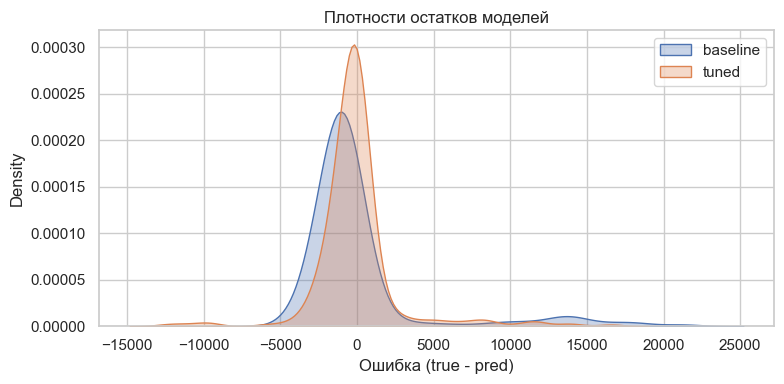

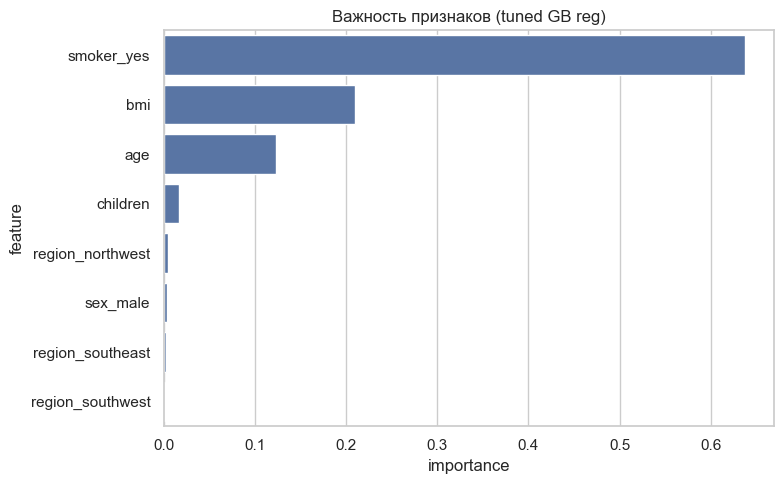

In [13]:
param_grid_reg = {
    "model__n_estimators": [120, 200, 260],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 4],
    "model__subsample": [0.7, 1.0],
}

gb_reg_search = GridSearchCV(
    estimator=gb_reg_baseline,
    param_grid=param_grid_reg,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)
gb_reg_search.fit(X_train_r, y_train_r)

best_gb_reg = gb_reg_search.best_estimator_
best_pred_reg = best_gb_reg.predict(X_test_r)

results_reg["tuned_gb"] = regression_report_dict(y_test_r, best_pred_reg)

plot_predictions(y_test_r, {"baseline": base_pred_reg, "tuned": best_pred_reg})
plot_residuals(y_test_r, {"baseline": base_pred_reg, "tuned": best_pred_reg})

feature_names_reg = (
    reg_preprocessor.named_transformers_["num"].get_feature_names_out(num_cols).tolist()
    + reg_preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(cat_cols).tolist()
)
plot_feature_importance(
    best_gb_reg.named_steps["model"].feature_importances_,
    feature_names_reg,
    "Важность признаков (tuned GB reg)",
)

Кастомная имплементация градиентного бустинга (регрессия)\
Классический бустинг по квадратичной ошибке на деревьях-регрессорах

In [14]:
class SimpleGBRegressor:
    def __init__(self, n_estimators=80, learning_rate=0.1, max_depth=2, min_samples_leaf=1, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        rng = np.random.default_rng(self.random_state)
        self.trees_ = []
        # начальное предсказание = среднее
        self.init_pred_ = y.mean()
        pred = np.full_like(y, self.init_pred_, dtype=float)
        for i in range(self.n_estimators):
            residual = y - pred
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state + i,
            )
            tree.fit(X, residual)
            update = tree.predict(X)
            pred += self.learning_rate * update
            self.trees_.append(tree)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        pred = np.full(X.shape[0], self.init_pred_, dtype=float)
        for tree in self.trees_:
            pred += self.learning_rate * tree.predict(X)
        return pred

Оценка кастомного бустинга (регрессия) на компактной выборке

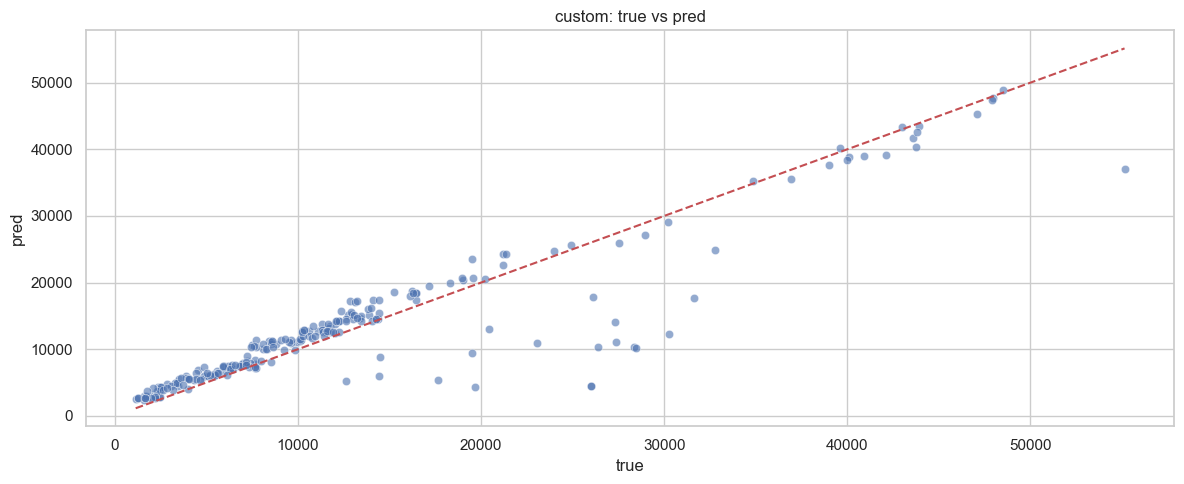

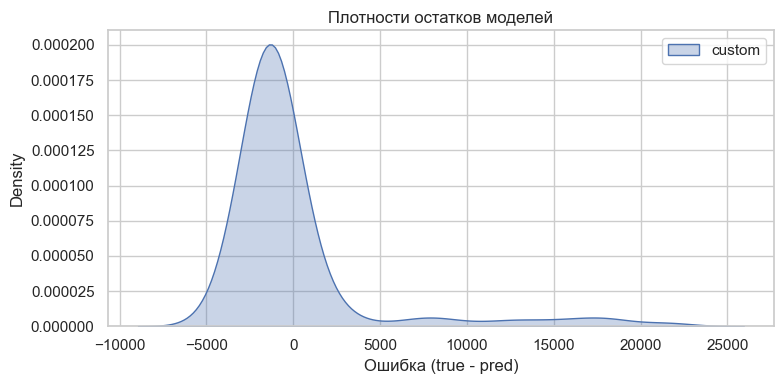


Метрики регрессии (градиентный бустинг)
                   mae       rmse      r2
baseline_gb  2286.7362  4330.0319  0.8778
tuned_gb     1449.1698  2895.1825  0.9454
custom_gb    2469.0808  4438.0049  0.8391


In [15]:
X_reg_small, _, y_reg_small, _ = train_test_split(
    reg_features, reg_target, train_size=1200, random_state=RANDOM_STATE
)

X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(
    X_reg_small, y_reg_small, test_size=0.2, random_state=RANDOM_STATE
)

custom_gb_reg = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        (
            "model",
            SimpleGBRegressor(
                n_estimators=100,
                learning_rate=0.08,
                max_depth=2,
                min_samples_leaf=5,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

custom_gb_reg.fit(X_train_rs, y_train_rs)
custom_pred_reg = custom_gb_reg.predict(X_test_rs)

results_reg["custom_gb"] = regression_report_dict(y_test_rs, custom_pred_reg)

plot_predictions(y_test_rs, {"custom": custom_pred_reg})
plot_residuals(y_test_rs, {"custom": custom_pred_reg})

show_results_table(results_reg, "Метрики регрессии (градиентный бустинг)")

## Выводы
Классификация: тюнингованный градиентный бустинг обеспечивает высокие F1 и ROC AUC (около 0.585 и 0.962 соответственно), базовый близок по качеству. Кастомная реализация уступает по полноте, хотя точность высока. Для производственного использования оптимален тюнингованный бустинг: он сочетает хорошую полноту, стабильную AUC и умеренную сложность модели.

Регрессия: тюнингованный бустинг значительно улучшил MAE и R² (MAE около 1450, R² около 0.95) по сравнению с базой; кастомная реализация заметно слабее. Выбором для применения является тюнингованная модель бустинга, способная улавливать нелинейности и взаимодействия признаков.

## Сводные выводы по всем ЛР
Классификация (COVID): наилучшее сочетание F1 и ROC AUC демонстрирует градиентный бустинг после тюнинга. Случайный лес также силен, особенно по F1, но бустинг сохраняет более высокую способность к ранжированию. Логистическая регрессия стабильна и интерпретируема, деревья и KNN уступают по AUC или полноте. Для прикладного использования рекомендуется тюнингованный бустинг; при упоре на интерпретацию — логистическая регрессия, при упоре на полноту и простой деплой — тюнингованный лес.

Регрессия (Insurance): лучше всего себя показал тюнингованный случайный лес, обеспечив низкий MAE и высокий R². Тюнингованный градиентный бустинг очень близок и может быть предпочтителен, если важна интерпретируемость важностей или устойчивость к нерегулярным паттернам. Линейные модели и KNN заметно уступают, что указывает на выраженные нелинейные зависимости в данных.

Кастомные реализации: полезны для понимания механики алгоритмов, но в большинстве случаев уступают библиотечным моделям по качеству и устойчивости. Их стоит рассматривать как учебный инструмент, а не как базу для прикладного использования.

Значение тюнинга и препроцессинга: подбор гиперпараметров и корректная обработка данных критичны для качества (особенно заметно на примерах KNN и градиентного бустинга в регрессии). Для несбалансированных задач необходимо контролировать метрики полноты и AUC, а для регрессии — оценивать не только MAE, но и RMSE, чтобы отслеживать крупные ошибки.
